# CNN 자동차 검출

### import

In [1]:
import matplotlib.image as mpimg
import matplotlib.pyplot as plt
import numpy as np
import cv2
import time

%matplotlib inline
import keras
from scipy.ndimage.measurements import label

Using TensorFlow backend.


### model load

In [2]:
model = keras.models.load_model('cnn-vehicle-3.h5')

### heatmap 함수

In [3]:
def add_heat(heatmap, bbox_list):
    for box in bbox_list:
        # Assuming each "box" takes the form ((x1, y1), (x2, y2))
        heatmap[box[0][1]:box[1][1], box[0][0]:box[1][0]] += 1
        
    return heatmap

### image에 label 그리기

In [4]:
def draw_labeled_bboxes(img, labels):
    box_list = []
    for car_number in range(1, labels[1]+1):
        # Find pixels with each car_number label value
        nonzero = (labels[0] == car_number).nonzero()
        # Identify x and y values of those pixels
        nonzeroy = np.array(nonzero[0])
        nonzerox = np.array(nonzero[1])
        # Define a bounding box based on min/max x and y
        bbox = ((np.min(nonzerox), np.min(nonzeroy)), (np.max(nonzerox), np.max(nonzeroy)))
        cv2.rectangle(img, bbox[0], bbox[1], (255,0,0), 6)        
        box_list.append(bbox)
    return img, box_list

### heatmap threshold

In [5]:
def apply_threshold(heatmap, threshold):
    # Zero out pixels below the threshold
    heatmap[heatmap <= threshold] = 0
    # Return thresholded map
    return heatmap

### image에서 차 검출

In [6]:
def find_cars(img, ystart, ystop, scale, pix_per_cell):
    heat = np.zeros_like(img[:,:,0]).astype(np.float)
    bboxes = []    
    draw_img = np.copy(img)    
    img_tosearch = img[ystart:ystop,:,:]
    ctrans_tosearch = cv2.cvtColor(img_tosearch, cv2.COLOR_BGR2RGB)
    ctrans_tosearch = img_tosearch

    if scale != 1:
        imshape = ctrans_tosearch.shape
        ctrans_tosearch = cv2.resize(ctrans_tosearch, (np.int(imshape[1]/scale), np.int(imshape[0]/scale)))

    
    ch1 = ctrans_tosearch[:,:,0]
    
    # Define blocks and steps as above
    nxblocks = (ch1.shape[1] // pix_per_cell)-1
    nyblocks = (ch1.shape[0] // pix_per_cell)-1 
    
    # 64 was the orginal sampling rate, with 8 cells and 8 pix per cell
    window = 64
    nblocks_per_window = (window // pix_per_cell)-1 
    cells_per_step = 2  # Instead of overlap, define how many cells to step
    nxsteps = (nxblocks - nblocks_per_window) // cells_per_step
    nysteps = (nyblocks - nblocks_per_window) // cells_per_step
 
    for xb in range(nxsteps):
        for yb in range(nysteps):
            ypos = yb*cells_per_step
            xpos = xb*cells_per_step
 
            xleft = xpos*pix_per_cell
            ytop = ypos*pix_per_cell
 
            # Extract the image patch
            subimg = cv2.resize(ctrans_tosearch[ytop:ytop+window, xleft:xleft+window], (64,64))
         
            Y_hats = model.predict(np.array( [subimg,] ))
            y_hats = Y_hats.argmax(axis=-1)
            test_prediction = y_hats[0]
            
            if test_prediction == 1:
                xbox_left = np.int(xleft*scale)
                ytop_draw = np.int(ytop*scale)
                win_draw = np.int(window*scale)
                bboxes.append(((xbox_left, ytop_draw+ystart),(xbox_left+win_draw,ytop_draw+win_draw+ystart)))

    heatmap = add_heat(heat, bboxes)                
                
    return heatmap, bboxes

### test 이미지에서 자동차 검출

In [7]:
img = cv2.imread('test_images/test9.jpg')

#this could be changed relative to image size
ystart = 400
ystop = 656

pix_per_cell = 8 # pixels per cell

heatmap_sum = np.zeros_like(img[:,:,0]).astype(np.float)

for scale in (1.5, 2.0):
    heatmap, bboxes = find_cars(img, ystart, ystop, scale, pix_per_cell)
    heatmap_sum = np.add(heatmap_sum,heatmap)

### 검출 된 이미지 heatmap

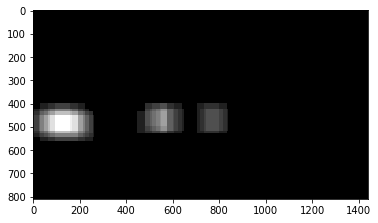

In [8]:
heatmap = apply_threshold(heatmap_sum, 1)
plt.imshow(heatmap, cmap='gray')

### heatmap binary

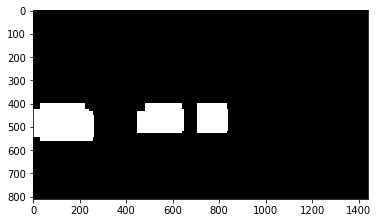

In [9]:
heatmap = np.clip(heatmap, 0, 1)
plt.imshow(heatmap, cmap='gray')

### 자동차 이미지 라벨

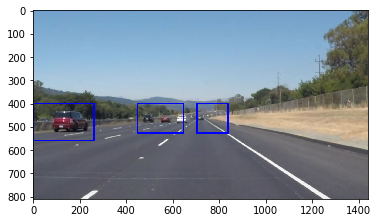

In [10]:
labels = label(heatmap)
draw_img, bbox_list = draw_labeled_bboxes(np.copy(img), labels)
plt.imshow(cv2.cvtColor(draw_img, cv2.COLOR_BGR2RGB))